In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, colors, colorbar

# Import MNE, as well as the MNE sample dataset
import mne
from mne.datasets import sample

# FOOOF imports
from fooof import FOOOFGroup
from fooof.bands import Bands
from fooof.analysis import get_band_peak_fg
from fooof.plts.spectra import plot_spectra

from utils.kuramoto import KuramotoFast
from utils.criticality import dfa

import scipy as sp

C:\Users\vlamyr\AppData\Local\Temp\2\ipykernel_21772\1821735478.py:10: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof import FOOOFGroup


### Data-driven PSD in a model

A power spectrum of Hierarchical Kuramoto model depends on its operating point (which can be controlled by local and inter-areal coupling strength) and distribution of oscillator frequencies. In the most simple way their distribution follows Gaussian or uniform formulas but in real electrophysiological recordings we rarely see unimodal spectrum. However, it is possible to run a model with multi-frequency power spectrum by initializing the distribytion of oscillator frequencies in data-driven way.

At first, lets load some data following the FOOOF tutorial ( https://fooof-tools.github.io/fooof/auto_examples/analyses/plot_mne_example.html )

In [163]:
# Get the data path for the MNE example data
raw_fname = sample.data_path() / 'MEG' / 'sample' / 'sample_audvis_filt-0-40_raw.fif'

# Load the example MNE data
raw = mne.io.read_raw_fif(raw_fname, preload=True, verbose=False)

# Select EEG channels from the dataset
raw = raw.pick(['eeg'], exclude='bads')
# Set the reference to be average reference
raw = raw.set_eeg_reference()

data_psd = raw.compute_psd(method="welch", fmin=1, fmax=40, tmin=0, tmax=250,
                      n_overlap=150, n_fft=300)
data_spectra, data_freqs = data_psd.get_data(return_freqs=True)

# Initialize a FOOOFGroup object, with desired settings
fg = FOOOFGroup(peak_width_limits=[1, 6], min_peak_height=0.15,
                peak_threshold=2., max_n_peaks=6, verbose=False)

# Define the frequency range to fit
freq_range = [1, 40]
fg.fit(data_freqs, data_spectra, freq_range)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Removing existing average EEG reference projection.
Effective window size : 1.998 (s)


The basic idea behind is simple: we are interested in oscillatory components here, thus we subtract the aperiodic 1/f slope using the FOOOF method and use it as a reference data-driven distribution of underlying frequencies to sample our actual oscillator frequencies. 

In [164]:
spectrum_flat_chanwise = np.zeros((59, 78))
freqs_sampled_chanwise = np.zeros((59, 1000))

for i in range(59):
    chan_psd_flat = fg.get_fooof(i).power_spectrum - fg.get_fooof(i)._ap_fit
    chan_psd_flat = np.clip(chan_psd_flat, a_min=0.0, a_max=None)
    chan_psd_normed = chan_psd_flat / chan_psd_flat.sum()
    
    freqs_sampled_chanwise[i] = np.random.choice(data_freqs, size=1000, p=chan_psd_normed)
    spectrum_flat_chanwise[i] = chan_psd_normed

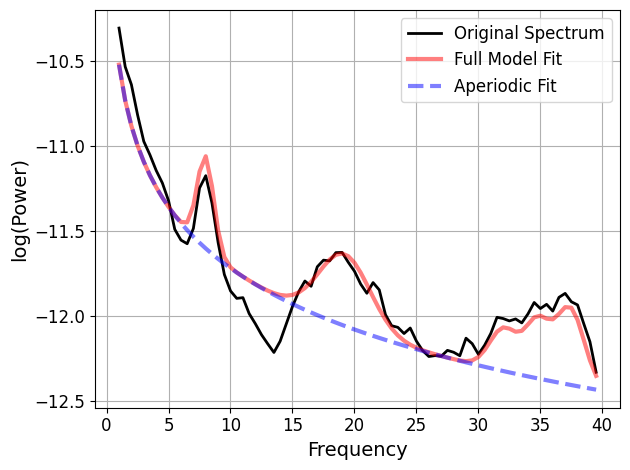

In [167]:
fig, ax = plt.subplots()
fg.get_fooof(0).plot(ax=ax)

In [5]:
np.random.seed(42)
uniform_sc = np.random.uniform(0.5, 1.5, size=(59,59))
uniform_sc = (uniform_sc + uniform_sc.T)/2
uniform_sc = uniform_sc / uniform_sc.mean()

sfreq = 200

dfa_win_lengths = np.geomspace(sfreq, 300*sfreq//5, 30)

Since the variability in the oscillator frequencies is much higher in contrast to the basic Gaussian distribution, the coupling strengths should also be increased and the same with noise to prevent too stable activity. 

The exact magnitude of control parameters for arbiraty power spectrum is an ongoing research and if you want to apply it for your own data we would recommend starting with short (~30 seconds) simulations  with coarse coupling strength grid to verify the existance of phase transition (model order growing from 0 to ~0.5 and emergence of LRTCs). If the model order doesnt grow - the upper boundary for coupling strength should be increased.

In [ ]:
L = 5

k_values = np.linspace(0, 130, 40)

order_as_k = np.zeros((len(k_values), 59))
dfa_as_k = np.zeros((len(k_values), 59))

model_psd_size = 59

psd_as_k = np.zeros((len(k_values), 59, 59))

for k_idx, k in enumerate(k_values):
    mdl = KuramotoFast(1000, 200, [k]*59, uniform_sc*L, [10]*59, noise_scale=15.0, custom_omegas=freqs_sampled_chanwise, disable_tqdm=True)
    data_sim = mdl.simulate(360)

    data_sim_cut = data_sim[..., 30*200:]

    data_envelope = np.abs(data_sim_cut)

    order_as_k[k_idx] = np.abs(data_sim).mean(axis=-1)

    dfa_values = dfa(data_envelope, dfa_win_lengths)[2]
    model_psd, model_psd_freqs = mne.time_frequency.psd_array_welch(data_sim.real, sfreq=200, fmin=1, fmax=40, n_overlap=150, n_fft=300, verbose=False)

    dfa_as_k[k_idx] = dfa_values
    psd_as_k[k_idx] = model_psd


In [168]:
psd_interp_as_k = np.zeros((len(k_values), *data_psd.shape))
psd_corr_as_k = np.zeros((len(k_values), 59))

for i in range(len(k_values)):
    for ch_idx in range(59):
        # because of different sampling rate between the data and model, we need to interpolate model spectrum to data
        psd_interp_as_k[i, ch_idx] = np.interp(data_freqs, model_psd_freqs, psd_as_k[i, ch_idx])
        # pearson correlation as metric of similarity between the data and model spectra.
        psd_corr_as_k[i, ch_idx] = sp.stats.pearsonr(psd_interp_as_k[i, ch_idx], spectrum_flat_chanwise[ch_idx])[0]

At first, even in heterogeneous model in terms of underlying frequencies, the LRTCs emerge during the phase transision.

At second, the correlation between the data and model spectra peaks at the subcritical side of the extended critical regime and dips in the supercritical regime!

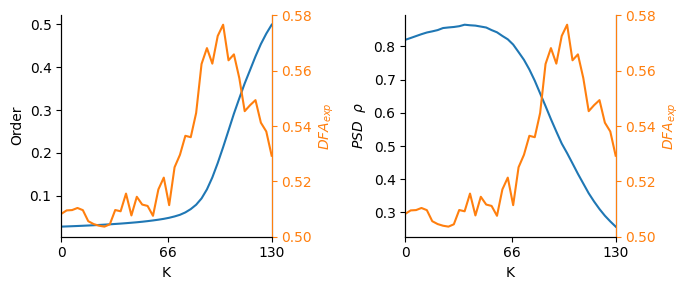

In [130]:
fig, axes = plt.subplots(figsize=(7,3), ncols=2)
axes_dfa = [ax.twinx() for ax in axes]

for ax, ax_twin, obs_name, obs_arr in zip(axes, axes_dfa, ['Order', r'$PSD$  $\rho$'], [order_as_k.mean(axis=-1), psd_corr_as_k.mean(axis=-1)] ):
    ax.plot(k_values, obs_arr, color='C0')
    ax_twin.plot(k_values, dfa_as_k.mean(axis=-1), color='C1')

    ax.set_xlabel('K', fontsize=10)
    ax.set_ylabel(obs_name, fontsize=10)
    ax_twin.set_ylabel(r'$DFA_{exp}$', fontsize=10, color='C1')
    
    ax.set_xticks(k_values[[0, len(k_values)//2, ~0]].astype(int))
    ax.set_xlim(k_values[[0, ~0]])

    ax_twin.spines['top'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax_twin.spines['right'].set_color('C1')
    ax_twin.tick_params(axis='y', colors='C1')

fig.tight_layout()


Looking closer at the model PSD at different regimes (please note that for visualization pursposes the PSD was normalized on its STD):

1. Subcritical and critical models show peaks resampling the data PSD but critical model has higher similarity with the data.

2. Supercritical model, on the other hand, is almost completely dominated by a single frequency that is the most promiment in the distribution of oscillator frequencies and later collapses to almost a perfect oscillation with delta-function in the spectra.


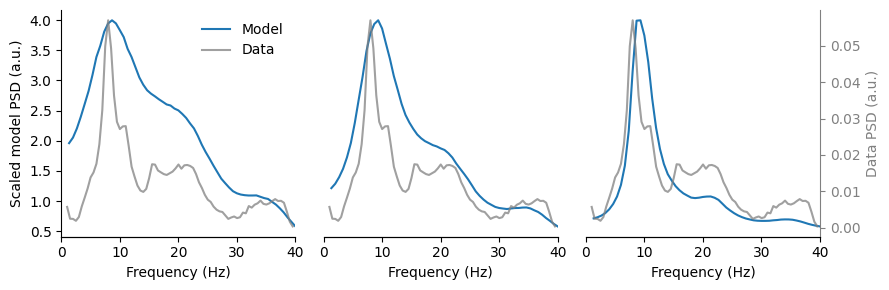

In [162]:
fig, axes = plt.subplots(figsize=(9,3), ncols=3)
axes_data_psd = [ax.twinx() for ax in axes]

lines_handles = list()

for k_idx, ax, ax_twin in zip([0, 10, 20], axes, axes_data_psd):

    to_plot = psd_as_k[k_idx].mean(axis=0)
    to_plot /= to_plot.std()


    model_psd_handles = ax.plot( model_psd_freqs, to_plot, label='Model')
    data_psd_handles = ax_twin.plot(data_freqs, spectrum_flat_chanwise.mean(axis=0), color='gray', alpha=0.75, label='Data')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_xlabel('Frequency (Hz)', fontsize=10)

    ax.set_xlim([0, 40])

    if (ax is axes[0]):
        lines_handles += model_psd_handles
        lines_handles += data_psd_handles

for ax in axes_data_psd[:2]:
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

for ax in axes[1:]:
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)


axes_data_psd[~0].spines['left'].set_visible(False)
axes_data_psd[~0].spines['top'].set_visible(False)

axes[0].set_ylabel('Scaled model PSD (a.u.)', fontsize=10)
axes_data_psd[~0].set_ylabel('Data PSD (a.u.)', fontsize=10, color='gray')


axes[0].legend(handles=lines_handles, fontsize=10, frameon=False)

axes_data_psd[~0].spines['right'].set_color('gray')
axes_data_psd[~0].tick_params(axis='y', colors='gray')


fig.tight_layout()